# Flow-based generative models
---

## Введение

В задачах генерации часто можно встретить, что объекты генерируются из нормального распределения. Таким образом задача генерации сводится к нахождению такой функции, которая переводит вектора $z$ нормального распределения в вектора $x$ реального распределения (того, что хотим генерировать). На картинке ниже показано как разные модели решают эту задачу.

<figure>
<img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/three-generative-models.png" alt="Примеры схем генеративных моделй" style="width:60%">
<figcaption align = "center">Примеры схем генеративных моделй</figcaption>
</figure>

У каждого подхода есть свои проблемы, но главная проблема GAN и VAE заключается в том, что при обучении никак не фигурирует реальное распределение объектов $x$. Нормализирующие потоки предлягают довольно элегантное решение этой проблемы.

__Задача:__

Построить модель, критерий обучения которой включал бы в себя связь распределения $x$ с распределением $z$.

__Идея:__

Построим модель преобразующую простое распределение в реальное при помощи последовательных преобразований обратимыми функциями, которые будем называть "потоками". Ниже на рисунке представлена иллюстрация этого процесса

<figure>
<img src="https://lilianweng.github.io/posts/2018-10-13-flow-models/normalizing-flow.png" alt="Примеры схем генеративных моделй" style="width:100%">
<figcaption align = "center">Иллюстрация преобразования нормально распределенного z0 в zK из реального  распределения.</figcaption>
</figure>

Благодаря наличию обратимых потоков, плотность $p_x = p_K(z_K)$ пожно расписать через простую плотнсть нормального распределения $p_0(z_0)$ как
$$
p_x = p_K(z_K) = p_0(z_0)\prod\limits_{i=1}^K\left|\det\dfrac{df_i}{dz_{i-1}}\right|^{-1}
$$
и логарифмируя правую и левую части можно получить
$$
\log p_x = \log p_K(z_K) = \log p_0(z_0) - \sum\limits_{i=1}^K\log\left|\det\dfrac{df_i}{dz_{i-1}}\right|
$$
где $\frac{df_i}{dz_{i-1}}$ — Якобиан, матрица частных производных функции, а $\det\frac{df_i}{dz_{i-1}}$ — ее определитель, а $K$ — число потоков.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from tqdm.notebook import tqdm
from matplotlib import gridspec
from sklearn.datasets import make_circles, make_moons

import warnings
warnings.filterwarnings("ignore")

In [2]:
class NormalizingFlowsModel(nn.Module):
    """Модель рассчета нормализующих потоков

    Parameters
    ----------
    flows: torch.nn.ModuleList
        Список потоков, применяющихся последовательно
    """
    def __init__(self, flows: nn.ModuleList):
        super().__init__()
        self.flows = flows

    def forward(self, x: torch.Tensor):
        """Прямое преобразование из исходного расперделения в нормальное.

        Parameters
        ----------
        x: torch.Tensor
            Тензор исходного распределения признакового пространства

        Returns
        -------
        z: torch.Tensor
            Тензор ростого распределения латентнго пространства
        log_det_jac: torch.Tensor
            Тензор суммы логарифмов определителей Якобиана потока f: p(X) -> q(Z)
        """
        log_det_jac = 0
        z = x
        for flow in self.flows:
            z, ldj = flow(z)
            log_det_jac = log_det_jac + ldj
        return z, log_det_jac

    def inverse(self, z: torch.Tensor):
        """Прямое преобразование из нормального расперделения в исходное.

        Parameters
        ----------
        z: torch.Tensor
            Тензор ростого распределения латентнго пространства

        Returns
        -------
        x: torch.Tensor
            Тензор исходного распределения признакового пространства
        """
        log_det_jac = 0
        x = z
        for flow in self.flows[::-1]:
            x, ldj = flow.inverse(x)
            log_det_jac = log_det_jac + ldj
        return x, log_det_jac

## Постановка оптимизационной задачи

Обучать такую модель будем через минимизацию отрицательного логарифма функции правдоподобия. Получить ее просто, так как у нас уже есть формула рассчета $p_K(z_K)$.
$$
\mathcal{L} = - \dfrac{1}{N}\sum\limits_{j=1}^N \log p_K(z_K^{(j)}) = - \dfrac{1}{N}\sum\limits_{j=1}^N \left[\log p_0(z_0^{(j)}) - \sum\limits_{i=1}^K \log\left|\det\dfrac{df_i}{dz_{i-1}}\right|^{(j)}\right]
$$
где $N$ — число элементов выборки.

При этом основное требование к функции потока $f_i$ — она должна быть легко обратима и ее Якобиан должен легко считаться.

In [3]:
class NLLoss(nn.Module):
    """Функция потерь отрицательного логарифма правдоподобия

    Parameters
    ----------
    x_size: tuple
        Размерность изображения
    loc: float
        Смещение распределения, стандартно 0
    scale: float
        Масштаб распределения, стандартно 1
    """

    def __init__(self, x_size, loc: float = 0., scale: float = 1.):
        super().__init__()
        self.coef = np.prod(x_size)
        self.prior = torch.distributions.Normal(loc, scale)

    def forward(self, z: torch.Tensor, log_det_jac: torch.Tensor):
        """
        Parameters
        ----------
        z: torch.Tensor
            Тензор латентного пространства
        log_det_jac: torch.Tensor
            Логарифм определителя Якобиана

        Returns
        -------
        loss: torch.Tensor
            Значение функции потерь
        """
        log_prob_z = self.prior.log_prob(z).flatten(1).sum(-1)  # Логарифм вероятности нормального распределения
        loss = - (log_det_jac + log_prob_z).mean()              # Добавляем сумму логарифмов определителей Якобианов
        loss = loss / self.coef                                 # Нормируем по размерности исходного пространства
        return loss

## Affine coupling layer

Теперь рассмотрим используемые потоки. Самым основным потоком можно считать __Affine coupling layer__. Задается он следующим образом
1. Первые $d$ шагов ничего не происходит (эквивалентное преобразование)
2. Начиная с шага $d+1$ применяется аффинное преобразование вида

$$
f =
\begin{cases}
y_i = x_i,~\forall i=1,2,\dots,d \\
y_i = x_i \odot \exp(s(x_{i-d})) + t(x_{i-d}),~\forall i=d+1,\dots,D
\end{cases}
$$

где $s(\cdot)$ — масштабирование, $t(\cdot)$ — смещение, а $\odot$ — поэлементное умножение. Для того чтобы половина вектора не проходила от потока к потоку тривиальное преобразование (первое в системе), принято чередовать их местами.

Однако обычно чередование первого и второго уравнения системы можно представить в виде бинарной маски $b$. С ее помощью афинное преобразование можно переписать как
$$
y = b\odot x + (1 - b)\odot\left(x \odot \exp(s(b\odot x)) + t(b\odot  x)\right)
$$

И тогда маску можно уже задать разную. Чаще всего ипользуют "шахматную" или "канальную" маски.

<p align="center">
  <img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/tutorial_notebooks_tutorial11_NF_image_modeling_33_1.svg" alt="Sublime's custom image"/>
  <img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/tutorial_notebooks_tutorial11_NF_image_modeling_33_2.svg" alt="Sublime's custom image"/>
</p>

В твком виде логарифм определителя Якобиана имеет вид
$$
\log\left|\det\dfrac{df}{dx}\right| = \sum\limits_i s(x_i)
$$

In [4]:
class AffineCouplingLayer(nn.Module):
    """Афинный поток

    Parameters
    ----------
    scale: nn.Module
        Сеть моделирующая преобразование масштаба
    translation: nn.Module
        Сеть моделирующая преобразование смещения
    mask: torch.Tensor
        Маска для превращения части преобразований в тривиальные
    """

    def __init__(self, scale: nn.Module, translation: nn.Module, mask: torch.Tensor):
        super().__init__()

        self.scale = scale
        self.translation = translation
        self.mask = nn.Parameter(mask, requires_grad=False)

    def forward(self, x: torch.Tensor, img: torch.Tensor = None):
        b = self.mask
        y = b * x
        if img is not None:     # Понадобится дальше при деквантизации
            s = self.scale(torch.cat((y, img), dim=1))
            t = self.translation(torch.cat((y, img), dim=1))
        else:
            s = self.scale(y)
            t = self.translation(y)
        z = y + (1 - b) * (x * torch.exp(s) + t)
        log_det_jac = ((1 - b) * s).flatten(start_dim=1).sum(-1)
        return z, log_det_jac

    def inverse(self, z: torch.Tensor, img: torch.Tensor = None):
        b = self.mask
        y = b * z
        if img is not None:     # Понадобится дальше при деквантизации
            s = self.scale(torch.cat((y, img), dim=1))
            t = self.translation(torch.cat((y, img), dim=1))
        else:
            s = self.scale(y)
            t = self.translation(y)
        x = y + (1 - b) * ((z - t) * torch.exp(-s))
        log_det_jac = ((1 - b) * (-s)).flatten(start_dim=1).sum(-1)
        return x, log_det_jac

In [5]:
def create_mask(shape: tuple, axis: int, reverse: bool = False):
    """Создаем маску чередования

    Parameters
    ----------
    shape: tuple
        Размерность маски
    axis: int
        Ось относительно которой происходит чередование. max_axis + 1 — шахматная маска
    reverse: bool
        Поменять порядок нулей и елиниц в маске

    Returns
    -------
    mask: torch.Tensor
        Полученная маска
    """
    slices = [slice(0, num) for num in shape]
    m1 = np.mgrid[slices]
    m2 = np.indices((len(shape), *shape)).sum(axis=0)
    mask = torch.from_numpy(np.vstack((m1, m2)))
    mask = mask[axis]
    mask = mask % 2
    return 1 - mask if reverse else mask

## Эксперимент с распределением

Для начала попробуем провести эксперимент с двумерным распределением. В качестве распределения возьмем `make_moons` из `scikit-learn`.

In [6]:
class Transform(nn.Module):
    """Сеть для афинного потока.

    Parameters
    ----------
    input_dim: int
        Размер входного пространства
    hidden_dim: int
        Расмер скрытого слоя
    use_scale: bool
        Метка использования масштабирования выхода сети
    """

    def __init__(self, input_dim: int, hidden_dim: int, use_scale: bool = False):
        super().__init__()

        self.use_scale = use_scale
        self.transform = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )
        if self.use_scale:
            self.scale = nn.Parameter(torch.Tensor(input_dim))
            torch.nn.init.normal_(self.scale)

    def forward(self, x):
        x = self.transform(x)
        if self.use_scale:
            x = F.relu(x)
            x = x * self.scale  # Нужно чтобы значения не росли слишком сильно
        return x

In [7]:
def loss_plot(loss, ax=None):
    ax = plt.subplot() if ax is None else ax
    ax.plot(loss)
    ax.grid(axis='y')
    ax.set_ylabel('Loss values')
    ax.set_xlabel('Epoches')
    ax.set_title('Loss')
    return ax

def points_plot(x, z, inverse: bool = False, axs = None):
    axs = plt.subplots(n_col=2) if axs is None else axs
    ax1, ax2 = axs
    ax1.scatter(x[:, 0], x[:, 1], s=1)
    ax2.scatter(z[:, 0], z[:, 1], s=1)
    ax1.set_title('Gen sample $x$' if inverse else 'Real sample $x$')
    ax2.set_title('Real sample $z$' if inverse else 'Gen sample $z$')
    return ax1, ax2

def simple_experiment(model, optimizer, criterion, distr, prior, epoches: int = 30, **distr_kwargs):

    pbar = tqdm(total=epoches)
    total_loss = []

    with pbar:

        for i in range(epoches):

            sample, _ = distr(**distr_kwargs)
            sample = torch.from_numpy(sample).float()

            optimizer.zero_grad()
            z, log_det_jac = model(sample.to(device))
            loss = criterion(z, log_det_jac)
            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_description("Epoch %i, Loss: %.4f" %(i+1, loss.item()))
            total_loss.append(loss.item())

    fig = plt.figure(tight_layout=True, figsize=(5, 7))
    gs = gridspec.GridSpec(3, 2)

    ax1 = fig.add_subplot(gs[0, :])
    loss_plot(total_loss, ax=ax1)

    z = prior.sample((5000, )).to(device)
    x = model.inverse(z)[0]
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    points_plot(x.cpu().detach(), z.cpu().detach(), inverse=True, axs=[ax2, ax3])

    x = make_moons(n_samples=5000, noise=0.05)[0]
    x = torch.from_numpy(x).float().to(device)
    z = model(x)[0]
    ax2 = fig.add_subplot(gs[2, 0])
    ax3 = fig.add_subplot(gs[2, 1])
    points_plot(x.cpu().detach(), z.cpu().detach(), inverse=False, axs=[ax2, ax3])

    plt.show()

    return model

  0%|          | 0/1000 [00:00<?, ?it/s]

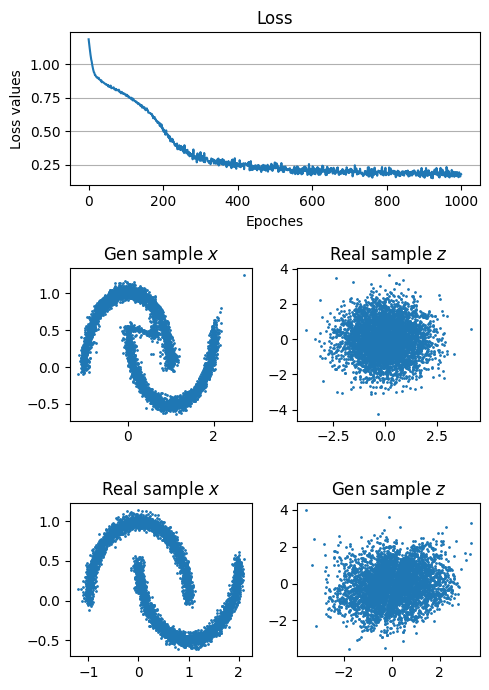

In [8]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512

flows = nn.ModuleList([
    AffineCouplingLayer(
        Transform(2, 128, use_scale=True),
        Transform(2, 128),
        create_mask((2, ), 1, reverse=bool(i % 2))
    )
    for i in range(8)
])
model = NormalizingFlowsModel(flows).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = NLLoss((2, ))
prior = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

model = simple_experiment(model, optimizer, criterion, make_moons, prior, epoches=1000, n_samples=512, noise=0.05)

Интересно посмотреть на то, как от потока к потоку менялось распределение $p_i(z_i)$. Его мы сможем посмотреть воспользовавшись формулой соответствия $p_i(z_i)$ к нормальному $p_0(x_0)$
$$
p_i(z_i) = p_0(z_0)\prod_{k=i}^K \det\left|\dfrac{df_k}{dz_{k-1}}\right|
$$
Видим, что преобразование $p_0(z_0)$ в $p_K(z_K)$ выглядит довольно хаотично, а последний поток вообще оказывает малое влияние на результат. Вдальнейшем мы еще вернемся к вопросу стабильности нормализующих потоков.

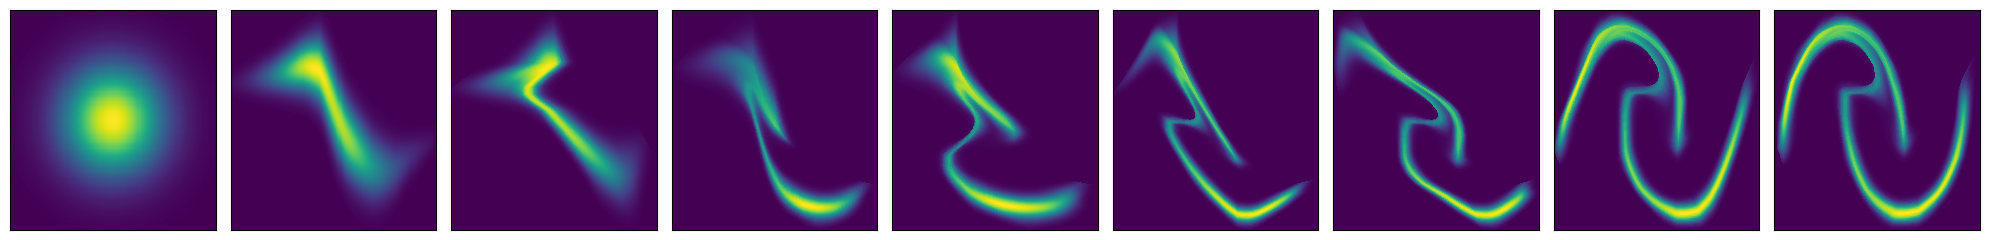

In [9]:
plt.figure(figsize=(20, 2.5), tight_layout=True)
distr = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

n = 200
x = torch.linspace(-3, 3, n)
xx, yy = torch.meshgrid((x, x))
zz = torch.stack((xx.flatten(), yy.flatten()), dim=-1).squeeze()

log_prob_z = distr.log_prob(zz)

ax = plt.subplot(1,9,1)
ax.pcolormesh(xx.view(n, n).data, yy.view(n, n).data, log_prob_z.view(n, n).exp().data)

log_det_jac = 0
x = zz
for i, flow in enumerate(model.flows[::-1]):
    x, ldj = flow.inverse(x.to(device))
    log_det_jac = log_det_jac + ldj.cpu()
    x = x.cpu()

    prob_x = (log_prob_z - log_det_jac).exp()
    ax = plt.subplot(1,9,i+2)
    ax.pcolormesh(x[:, 0].view(n, n).data, x[:, 1].view(n, n).data, prob_x.view(n, n).data)

for ax in plt.gcf().axes:
    ax.set_facecolor(plt.cm.viridis(0.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Генерация изобрадений

Для решения задачи генерации изображений возьмем MNIST. Для простоты уменьшим его разрешение до 1x16x16. Также оставим значения как в кодировке в отрезке $[0, 255]$ и уменьшим число примеров в 2 раза.

In [10]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Lambda, Resize, Compose
from torchvision.utils import make_grid

In [11]:
transform = Compose([
    Resize(16),                 # Уменьшаем размер изображений
    ToTensor(),
    Lambda(lambda t: 255 * t),  # Приводим распределение обратно к диапазону [0, 255]
])

mnist = MNIST('../data/', download=True, transform=transform)
train, _ = torch.utils.data.random_split(mnist, [10000, 50000])
train = DataLoader(train, batch_size=125, shuffle=True, drop_last=True)

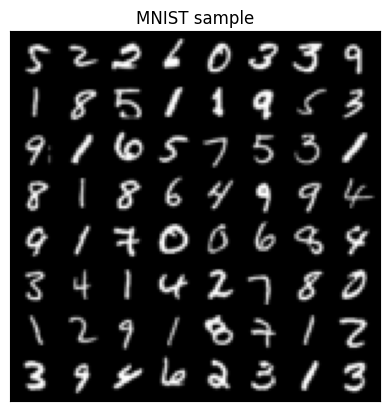

In [12]:
sample = next(iter(train))[0][:64]
plt.imshow(ToPILImage()(make_grid(sample.float(), normalize=True)))
plt.xticks([])
plt.yticks([])
plt.title('MNIST sample')
plt.show()

### Изменение размерности

В нормализующих потоках есть проблема с понижением размерности. Если в обычных сетях мы можем менять размерности входа и выхода довольно свободно, то афинный поток требует от нас равных размерностей входа и выхода.

Соответственно менять размерность можно только между потоками, но встает вопрос, как это сделать, какие пиксели выкинуть из изображения, а какие оставить.

Для нормализующих потоков вводят две трансформации _squieeze_ и _split_.

<p align="center">
  <img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/Squeeze_operation.svg" alt="Sublime's custom image" style="width:100%"/>
  <figcaption align = "center"><a href="https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html#Squeeze-and-Split">Иллюстрация трансформации Squeeze</a></figcaption>
  </figure>
</p>

То есть Squeeze перемешивает пиксели изображения, трансформируя размерность
$$C\times H\times W\to 4C\times\frac{H}{2}\times\frac{W}{2}$$

Операция Split разбивает изображение на две части по каналам, то есть трансформирует размерность как
$$2C\times H\times W\to C\times H\times W$$

In [13]:
class SqueezeFlow(nn.Module):
    """Поток сжатия
    """

    def forward(self, x):
        B, C, H, W = x.size()
        x = x.reshape(B, C, H//2, 2, W//2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, 4*C, H//2, W//2)
        return x, torch.zeros(x.size(0), device=x.device)

    def inverse(self, z):
        B, C, H, W = z.size()
        z = z.reshape(B, C//4, 2, 2, H, W)
        z = z.permute(0, 1, 4, 2, 5, 3)
        z = z.reshape(B, C//4, H*2, W*2)
        return z, torch.zeros(z.size(0), device=z.device)

In [14]:
class SplitFlow(nn.Module):
    """Поток разбиения по каналам

    Parameters
    ----------
    prior: torch.distributions
        Распределение, которым мы апроксимируем выборку. Стандартно выставлено нормальное.
    """

    def __init__(self, prior=None):
        super().__init__()
        if prior is None:
            self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        else:
            self.prior = prior

    def forward(self, x):
        x, x_split = x.chunk(2, dim=1)
        ldj = self.prior.log_prob(x_split).flatten(1).sum(-1)
        return x, ldj

    def inverse(self, z):
        z_split = self.prior.sample(sample_shape=z.shape).to(device)
        z = torch.cat([z, z_split], dim=1)
        ldj = self.prior.log_prob(z_split).flatten(1).sum(-1)
        return z, ldj

### Деквантизация распределения

Так как мы пытаемся связать нормальное распределение с распределением реальных данных, существует одна проблема, связанная с природой распределений. В прошлом разделе у нас было сложное непрерывное распределение, которое мы связывали с простым нормальным распределением, которое тоже явяется непрерывным.

Когда речь идет об изображениях, никакого непрерывного распределения быть не может, так как они кодируются натуральными значениями в отрезке $[0, 255]$, то есть пространство изображений имеет дискретную природу.

Так как потоки работают с непрерывными распределениями, нужно каким-то образом привеси изображение у нежному виду, для чего и используется деквантизация.

#### Простая деквантизация

Самым простым способом привести дискретные данные к непрерывным — добавить шум из непрерывного распределения как $v = x + u$, где $u\in[0, 1)^D$, где $D$ — размерность исходных данных. Таким образом распределение исходных данных меняется как
$$
p(x) \to p(v) = \int p(x+u)du = \mathbb{E}_{u\sim U(0, 1)^D}\left[p(x+u)\right]
$$
Далее мы нормируем $v$ от $0$ до $1$ и преобразем к нормальному распределению обратной функцией сигмоиды
$$
\sigma^{-1}(v) = \log{v} - \log{(1-v)}
$$
Чтобы убедиться, что функция является обратной, подставим в нее сигмоиду
$$
\sigma(v) = \dfrac{1}{1+e^{-v}}
$$
Получим
$$
\log{\dfrac{1}{1+e^{-v}}} - \log{\left(1-\dfrac{1}{1+e^{-v}}\right)} = \log{\left(\dfrac{1+e^{-v}}{(1+e^{-v})\cdot e^{-v}}\right)} = v
$$

Получили $\sigma^{-1}(\sigma(v)) = v$, что доказывает то, что наша функция и правда обратна к сигмоиде.

Делаем это для того чтобы не допустить больших значений функции потерь, так как изначально диапазон значений $[0, 255]$ сильно превышает $3\sigma$ нормального распределения.

Обратная функция деквантизации будет состоять из следующих шагов:
1. Используем функцию сигмоиды $\sigma(v)$
2. Возвращаем диапазон от $0$ до $255$ умножением на $255$
3. Обрезаем значения до дискретных

In [15]:
class Dequantization(nn.Module):
    """Деквантизация распределения

    Parameters
    ----------
    alpha: float
        Малая константа для масштабирования исходного изображения
    quants: int
        Число знаечений исходного дискретного распределения
    """

    def __init__(self, alpha: float = 1e-5, quants: int = 256):
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def sigmoid(self, z):
        """Функция сигмоиды
        """
        ldj1 = (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
        z = torch.sigmoid(z)
        ldj2 = -np.log(1 - self.alpha) * np.prod(z.shape[1:])
        z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        return z, ldj1 + ldj2

    def sigmoid_inv(self, z):
        """Обратная к сигмоиде функция
        """
        z = z * (1 - self.alpha) + 0.5 * self.alpha
        ldj1 = np.log(1 - self.alpha) * np.prod(z.shape[1:])
        ldj2 = (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
        z = torch.log(z) - torch.log(1-z)
        return z, ldj1 + ldj2

    def dequant(self, z):
        """Операция деквантизации
        """
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj = -np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

    def forward(self, z):
        z, ldj1 = self.dequant(z)
        z, ldj2 = self.sigmoid_inv(z)
        return z, ldj1 + ldj2

    def inverse(self, z):
        z, ldj = self.sigmoid(z)
        z = z * self.quants
        ldj = ldj + np.log(self.quants) * np.prod(z.shape[1:])
        z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)  # Приводим значения к дискретным
        return z, ldj

#### Вариационная деквантизация

Проблема пердыдущего подхода заключается в том, что мы использовали зашумление многомерным равномерным распределением, которое представляет из себя $D$-мерный куб, который в дальнейшем привести к более гладкому нормальному распределению будет затруднительно.

Другой проблемой является то, что изначально наши дискретные значения распределены не равномерно. Тогда давайте вместо равномерного шума обучим потоки зашумлять наши данные, приводя их к непрерывному виду распределения.

Для исправления этих недочетов заменим равномерное распределение на обучаемое распределение $q_θ(u|x)$ которое также находится в диапазоне $u\in[0, 1)^D$.

Такое распределение мы можем получить, обучив еще один поток, который будет на основании входного изображения и шума из нормального распределения строить шум. Чтобы ограничить размер шума мы можем обернуть его сигмоидой.

In [16]:
class VariationalDequantization(Dequantization):

    def __init__(self, var_flows: nn.Module, alpha: float = 1e-5, quants: int = 256):
        """Вариационная деквантизация распределения

        Parameters
        ----------
        var_flows: nn.Module
            Поток генерирующий шум
        alpha: float
            Малая константа для масштабирования исходного изображения
        quants: int
            Число знаечений исходного дискретного распределения
        """
        super().__init__(alpha=alpha, quants=quants)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z):
        z = z.to(torch.float32)
        img = (z / (self.quants - 1)) * 2 - 1

        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj1 = self.sigmoid_inv(deq_noise)
        ldj2 = 0
        for flow in self.flows:
            deq_noise, ldj_flow = flow(deq_noise, img)
            ldj2 = ldj2 + ldj_flow
        deq_noise, ldj3 = self.sigmoid(deq_noise)

        z = (z + deq_noise) / self.quants
        ldj4 = -np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj1 + ldj2 + ldj3 + ldj4

### Архитектура сети

Так как работаем с изображениями, в афинном потоке будем использовать сверточные сети. Частые элементы архитектуры в таких задачах следующие:
1. Конкатинирующий ELU
2. Нормирование по каналам
3. Стробирующие свертки

Разберем каждый пункт подробнее



#### Конкатинирующий ELU

Тут все просто. Входной тензор $x$, который подается в $\text{ELU}$, подается дважды, но второй раз отрицательный. То есть формулой выглядит так
$$
\text{ConcatELU}(x) = [\text{ELU}(x), \text{ELU}(-x)]
$$

<p align="center">
  <img src="https://pytorch.org/docs/stable/_images/ELU.png" alt="Sublime's custom image" style="width:50%"/>
  <figcaption align = "center"><a href="https://pytorch.org/docs/stable/generated/torch.nn.ELU.html">График функции активации ELU</a></figcaption>
  </figure>
</p>

In [17]:
class ConcatELU(nn.Module):
    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)

#### Нормализация по каналам
Аналогично нормализации по батчу, то есть преобразование
$$x ← \dfrac{x - \mu}{\sqrt{\sigma^2 + ɛ}}$$

Только размерность $\mu$ и $\sigma$ не по размеру батча, а по числу каналов $C$. Следовательно и инициализация выполняется так, чтобы  
$$\mathbb{E}_C[x] = 0, ~\text{Var}_C[x]=1$$

Так как ее мы будем использовать только внутри сети афинного потока, считать определитель якобиана нам не нужно, однако, если бы нормализация использовалась как отдельный поток, считать его нам бы пришлось.

Напомню, что батч нормализация — обучаемая, поэтому нам нужно еще добавить параметры для обучения.

In [18]:
class LayerNormChannels(nn.Module):

    def __init__(self, c_in, eps=1e-5):
        super().__init__()
        self.sigma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.mu = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.sigma + self.mu
        return y

#### Стробирующие свертки


Часто в нормализующих потоках можно увидеть использование в архитектуре стробирующих сверток. Причиной этому является использование масок в афинном потоке, так как эта архитектура хорошо показывает себя в востановлении изображений, что было показано в статье [Pixel Recurrent Neural Networks](https://arxiv.org/pdf/1601.06759.pdf).

<p align="center">
  <img src="https://neerc.ifmo.ru/wiki/images/thumb/c/cc/Pixel-1.png/450px-Pixel-1.png" alt="Sublime's custom image" style="width:50%"/>
  <figcaption align = "center">Иллюстрация из статьи: <a href="https://arxiv.org/pdf/1601.06759.pdf">Pixel Recurrent Neural Networks</a></figcaption>
  </figure>
</p>

In [19]:
class GatedConv(nn.Module):

    def __init__(self, c_in, c_hidden):
        super().__init__()

        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):

    def __init__(self, c_in, c_hidden=32, c_out=None, num_layers=3, use_scale=False):
        super().__init__()

        self.use_scale = use_scale
        c_out = c_in if c_out is None else c_out

        layers = [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [
                GatedConv(c_hidden, c_hidden),
                LayerNormChannels(c_hidden)
            ]
        layers += [
            ConcatELU(),
            nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)
        ]

        self.nn = nn.Sequential(*layers)
        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

        if self.use_scale:
            self.scale = nn.Parameter(torch.Tensor(c_out, 1, 1))
            torch.nn.init.normal_(self.scale)

    def forward(self, x):
        x = self.nn(x)
        if self.use_scale:
            x = F.tanh(x) * self.scale
        return x

### Эксперимент генерации

In [20]:
def mnist_experiment(dataloader, model, optimizer, criterion, epoches: int = 30):
    pbar = tqdm(total=epoches)
    total_loss = []
    prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
    with pbar:
        for i in range(epoches):
            epoch_loss = []
            for real_sample, _ in dataloader:

                optimizer.zero_grad()

                z, log_det_jac = model(real_sample.to(device))

                loss = criterion(z, log_det_jac)
                loss = loss / 64

                epoch_loss.append(loss.item())
                total_loss.append(loss.item())

                loss.backward()
                optimizer.step()

            pbar.update(1)
            pbar.set_description("Epoch %i, Loss: %.4f" %(i+1, np.mean(epoch_loss)))

    return model, total_loss

In [21]:
def create_multiscale_flow():
    flow_layers = [Dequantization()]
    flow_layers += [AffineCouplingLayer(
                        GatedConvNet(1, 16, use_scale=True),
                        GatedConvNet(1, 16),
                        create_mask((1, 16, 16), 4, (i % 2))
                    ) for i in range(3)]
    flow_layers += [SqueezeFlow()]
    for i in range(3):
        flow_layers += [AffineCouplingLayer(
                            GatedConvNet(4, 32, use_scale=True),
                            GatedConvNet(4, 32),
                            create_mask((4, 8, 8), 0, (i % 2))
                        )]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(3):
        flow_layers += [AffineCouplingLayer(
                            GatedConvNet(8, 64, use_scale=True),
                            GatedConvNet(8, 64),
                            create_mask((8, 4, 4), 0, (i % 2))
                        )]

    flow_model = nn.ModuleList(flow_layers)
    return flow_model

In [22]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

flows = create_multiscale_flow()
model = NormalizingFlowsModel(flows).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # , weight_decay=5 * 1e-5
criterion = NLLoss((1, 16, 16))

model, loss = mnist_experiment(train, model, optimizer, criterion, epoches=25)

  0%|          | 0/25 [00:00<?, ?it/s]

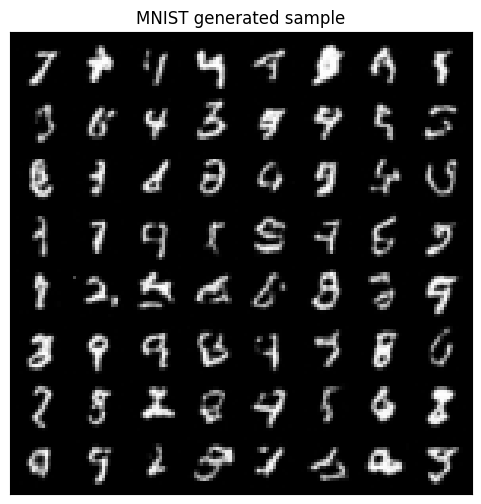

In [23]:
prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
z = prior.sample((64, 8, 4, 4)).to(device)
gen_imgs = model.inverse(z)[0]

plt.figure(figsize=(6, 6))
plt.imshow(ToPILImage()(make_grid(gen_imgs.float(), normalize=True)))
plt.title('MNIST generated sample')
plt.xticks([])
plt.yticks([])
plt.show()

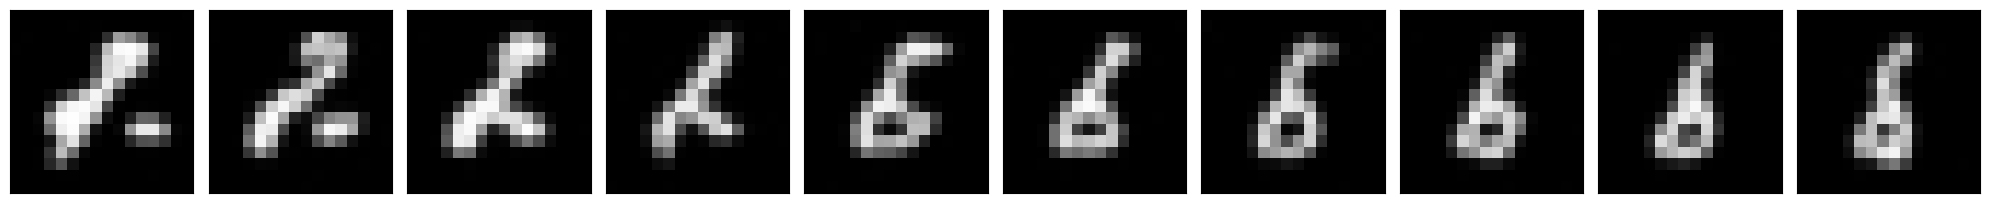

In [24]:
plt.figure(figsize=(20, 2.5), tight_layout=True)

z1, z2 = prior.sample((2, 8, 4, 4)).to(device)
for i, alpha in enumerate(torch.arange(0, 1, 0.1)):
    z = alpha * z1 + (1 - alpha) * z2
    x = model.inverse(z.unsqueeze(0))[0][0]
    plt.subplot(1, 10, i+1)
    plt.imshow(ToPILImage()(x))
for ax in plt.gcf().axes:
    ax.set_facecolor(plt.cm.viridis(0.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [25]:
def create_multiscale_flow2():
    var_flow = [AffineCouplingLayer(
                        GatedConvNet(2, 16, c_out=1, use_scale=True),
                        GatedConvNet(2, 16, c_out=1),
                        create_mask((1, 16, 16), 4, (i % 2))
                ) for i in range(3)]
    flow_layers = [VariationalDequantization(var_flow)]
    flow_layers += [AffineCouplingLayer(
                        GatedConvNet(1, 16, use_scale=True),
                        GatedConvNet(1, 16),
                        create_mask((1, 16, 16), 4, (i % 2))
                    ) for i in range(3)]
    flow_layers += [SqueezeFlow()]
    for i in range(3):
        flow_layers += [AffineCouplingLayer(
                            GatedConvNet(4, 32, use_scale=True),
                            GatedConvNet(4, 32),
                            create_mask((4, 8, 8), 0, (i % 2))
                        )]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(3):
        flow_layers += [AffineCouplingLayer(
                            GatedConvNet(8, 64, use_scale=True),
                            GatedConvNet(8, 64),
                            create_mask((8, 4, 4), 0, (i % 2))
                        )]

    flow_model = nn.ModuleList(flow_layers)
    return flow_model

In [26]:
random.seed(0);
np.random.seed(0);
torch.manual_seed(0);
torch.cuda.manual_seed(0);
torch.cuda.manual_seed_all(0);

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

flows = create_multiscale_flow2()
model = NormalizingFlowsModel(flows).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # , weight_decay=5 * 1e-5
criterion = NLLoss((1, 16, 16))

model, loss = mnist_experiment(train, model, optimizer, criterion, epoches=25)

  0%|          | 0/25 [00:00<?, ?it/s]

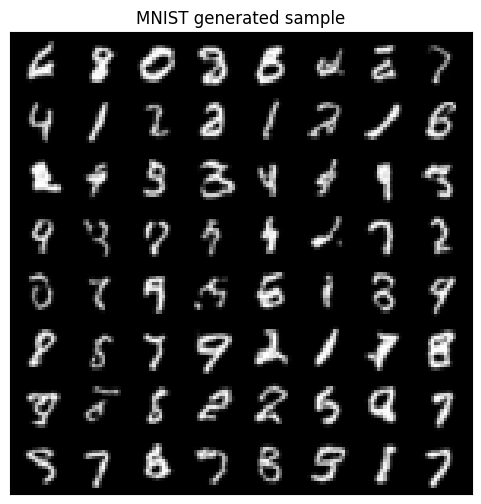

In [27]:
prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
z = prior.sample((64, 8, 4, 4)).to(device)
gen_imgs = model.inverse(z)[0]

plt.figure(figsize=(6, 6))
plt.imshow(ToPILImage()(make_grid(gen_imgs.float(), normalize=True)))
plt.title('MNIST generated sample')
plt.xticks([])
plt.yticks([])
plt.show()

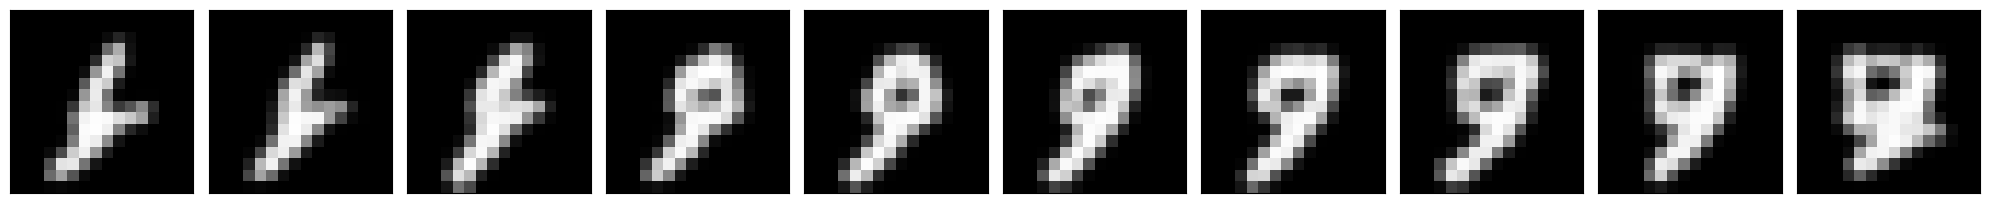

In [28]:
plt.figure(figsize=(20, 2.5), tight_layout=True)

z1, z2 = prior.sample((2, 8, 4, 4)).to(device)
for i, alpha in enumerate(torch.arange(0, 1, 0.1)):
    z = alpha * z1 + (1 - alpha) * z2
    x = model.inverse(z.unsqueeze(0))[0][0]
    plt.subplot(1, 10, i+1)
    plt.imshow(ToPILImage()(x))
for ax in plt.gcf().axes:
    ax.set_facecolor(plt.cm.viridis(0.))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Упражнения

1. Поиграться с параметрами (число потоков, число скрытых слоев в них).
2. Обучить MNIST на всей выборке без изменения размера.
3. В задании с двумерным распределением заменить `make_moons` например на `make_circles` или другой двумерный самплер точек.
4. Попробовать заменить архитектуру сети в афинном преобразовании.
5. Попробовать потоковую модель с одним переиспользующимся потоком, то есть создается один экземпляр потока $f$, которвый используется многократно (задано число пропусканий через поток $N$)
$$
\log p(x) = \log p(z) - \sum\limits^N_{i=1} \log\left|\det\dfrac{df}{dz_{i-1}}\right|,
$$
посмотреть, будет ли такая модель работать.

## Полезные ссылки

- [UvA DL Notebooks Tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html)
- [Flow-based Deep Generative Models](https://lilianweng.github.io/posts/2018-10-13-flow-models)